In [6]:
import visualkeras
import plotly.offline as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")
from tensorflow i

In [73]:
from tensorflow import keras
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten

In [17]:
def dataSet():
    df = pd.DataFrame(columns=['Class','Location'])
    basedir = '../3D-CNN-Gesture-recognition/leapGestRecog/'
    for folder in os.listdir(basedir):
        for Class in os.listdir(basedir+folder+'/'):
            for location in os.listdir(basedir+folder+'/'+Class+'/'):
                df = df.append({'Class':Class, 'Location':basedir+folder+'/'+Class+'/'+location},ignore_index=True)
            df = df.sample(frac = 1)
        return df
    

In [18]:
df = dataSet()
print(df.shape)
df.head()

(2000, 2)


,Class,Location
400,07_ok,../3D-CNN-Gesture-recognition/leapGestRecog/00...
1011,02_l,../3D-CNN-Gesture-recognition/leapGestRecog/00...
1599,07_ok,../3D-CNN-Gesture-recognition/leapGestRecog/00...
1734,04_fist_moved,../3D-CNN-Gesture-recognition/leapGestRecog/00...
257,01_palm,../3D-CNN-Gesture-recognition/leapGestRecog/00...


### Visualize Data

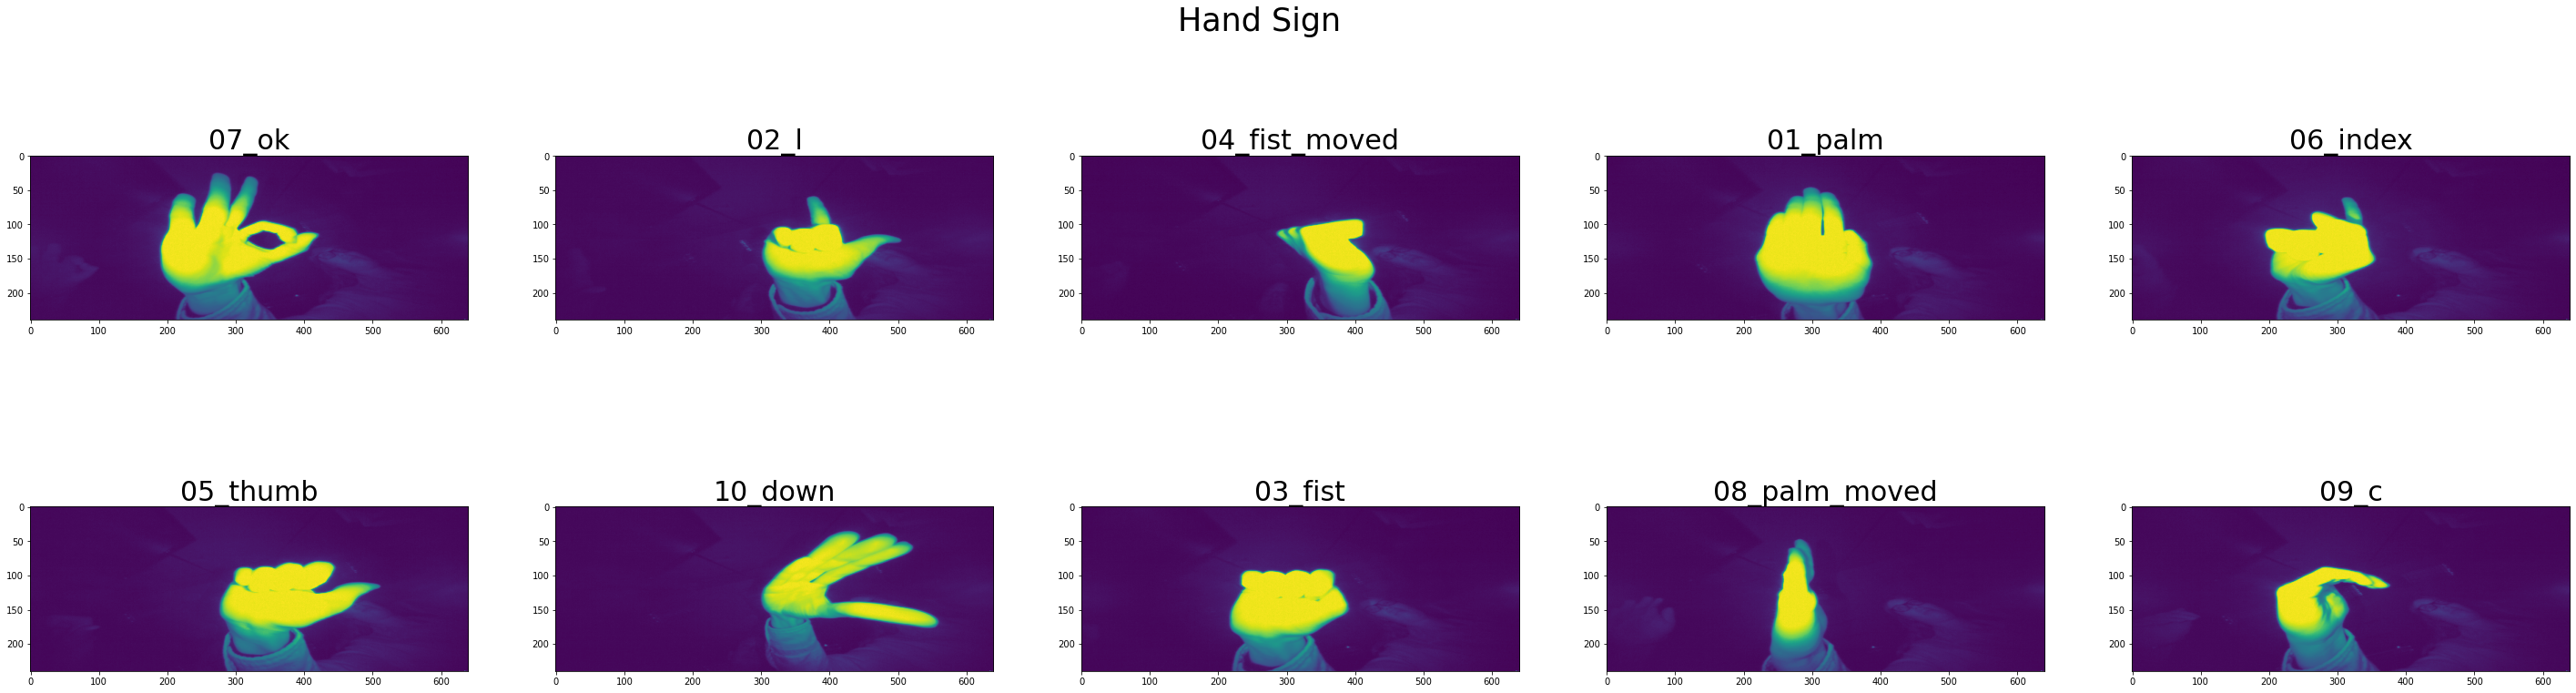

In [27]:
count = 1
f = plt.figure(figsize=(50,13))
for Class in df['Class'].unique():
    seg = df[df['Class']==Class]
    address = seg.sample().iloc[0]['Location']
    img = cv2.imread(address,0)
    ax = f.add_subplot(2,5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize=30)
    count = count+1
plt.suptitle("Hand Sign",fontsize=35)
plt.show()

In [21]:
img.shape

(240, 640)

In [28]:
w,  h = 64,64
total_class = 10

###  Creating data

In [31]:
from tqdm import tqdm

In [30]:
!pip install tdqm

     |████████████████████████████████| 76 kB 1.7 MB/s eta 0:00:01
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=c32671494484c84bc72c365b6210c3bd51139e3ab7dc0ddea5375df1efa66df6
  Stored in directory: /home/labina/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built tdqm


In [32]:
train_image = []
for location in tqdm(df.iloc[:]['Location']):
    img = cv2.imread(location,0)
    img = cv2.resize(img,(w,h),interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 2000/2000 [00:33<00:00, 60.32it/s]


In [39]:
from sklearn.preprocessing import OneHotEncoder
y = np.array(df.iloc[:]['Class'])
y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
print(enc.categories_)

[array(['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
       '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'],
      dtype=object)]


In [40]:
y = enc.transform(y).toarray()

In [41]:
print('Data:' +str(X.shape))
print('Output:'+str(y.shape))

Data:(2000, 64, 64, 1)
Output:(2000, 10)


In [42]:
print(X[0].reshape(w,h))

[[ 6  6  6 ...  6  6  5]
 [ 6  6  6 ...  6  5  5]
 [ 6  6  6 ...  5  5  5]
 ...
 [ 5  6  6 ...  7  7  7]
 [ 6  6  6 ...  8  7  7]
 [ 5  5  6 ...  7  6 10]]


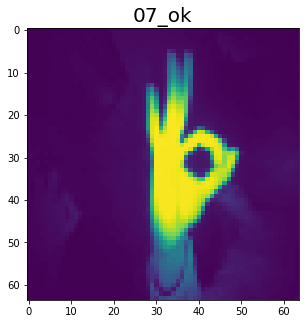

In [52]:
plt.figure(figsize=(20,5))
plt.imshow(X[0].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size=20)
plt.show()

In [53]:
y[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

### Spliting training and test data

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.1)

In [59]:
print('Train data:',(X_train.shape))
print('Test data:' ,(X_test.shape))
print('Train output:',(y_train.shape))
print('Test output:',(y_test.shape))

Train data: (1800, 64, 64, 1)
Test data: (200, 64, 64, 1)
Train output: (1800, 10)
Test output: (200, 10)


In [113]:
def wrap(Training_Output_Results , Opt , Act ,  history):
    epoch  = len(history.history['loss'])
    epochs = list(np.arange(1,epoch + 1,1))
    Optimizer = np.repeat(Opt,epoch).tolist()
    Activation = np.repeat(Act,epoch).tolist()
    cumiliated_res = {}
    cumiliated_res['Epochs']=epochs
    cumiliated_res['Optimizer']=Optimizer
    cumiliated_res['Activation_Function']=Activation
    cumiliated_res['Train_Loss']=history.history['loss']
    cumiliated_res['Train_Accuracy']=history.history['accuracy']
    cumiliated_res['Train_Precision']=history.history['precision']
    cumiliated_res['Train_Recall']=history.history['recall']
    cumiliated_res['Val_Loss']=history.history['val_loss']
    cumiliated_res['Val_Accuracy']=history.history['val_accuracy']
    cumiliated_res['Val_Precision']=history.history['val_precision']
    cumiliated_res['Val_Recall']=history.history['val_recall']
    convertDictionary = pd.DataFrame(cumiliated_res)
    Training_Output_Results = Training_Output_Results.append(convertDictionary)
    return Training_Output_Results

In [114]:
Optimisers = ['RMSprop','Adam','Adadelta','Adagrad']
Activation_function =['relu','sigmoid','softmax','tanh','softsign','selu','elu']

In [110]:
Optimisers = ['RMSprop','Adam']
Activation_function =['relu','tanh']

In [111]:
Activation_function[0]

'relu'

### Optimizer Analytics

In [85]:
input_shape = w,h

In [86]:
input_shape

(64, 64)

In [157]:
input_shape = w,h,1
def build_model(act , final_class ,input_shape):
        model = tf.keras.Sequential()
        
        model.add(Conv2D(
            8, (3,3), activation=act, input_shape=input_shape
        ))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
        model.add(Conv2D(16, (3,3), activation=act))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
        model.add(Conv2D(32, (3,3), activation=act))
        model.add(Conv2D(32, (3,3), activation=act))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
        model.add(Conv2D(64, (2,2), activation=act))
        model.add(Conv2D(64, (2,2), activation=act))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(256))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes, activation='softmax'))
        
        return model

In [154]:
def wrap(Training_Output_Results , Opt , Act ,  history):
    epoch  = len(history.history['loss'])
    epochs = list(np.arange(1,epoch + 1,1))
    Optimizer = np.repeat(Opt,epoch).tolist()
    Activation = np.repeat(Act,epoch).tolist()
    cumiliated_res = {}
    cumiliated_res['Epochs']=epochs
    cumiliated_res['Optimizer']=Optimizer
    cumiliated_res['Activation_Function']=Activation
    cumiliated_res['Train_Loss']=history.history['loss']
    cumiliated_res['Train_Accuracy']=history.history['accuracy']
    cumiliated_res['Train_Precision']=history.history['precision']
    cumiliated_res['Train_Recall']=history.history['recall']
    cumiliated_res['Val_Loss']=history.history['val_loss']
    cumiliated_res['Val_Accuracy']=history.history['val_accuracy']
    cumiliated_res['Val_Precision']=history.history['val_precision']
    cumiliated_res['Val_Recall']=history.history['val_recall']
    convertDictionary = pd.DataFrame(cumiliated_res)
    Training_Output_Results = Training_Output_Results.append(convertDictionary)
    return Training_Output_Results

In [159]:
Optimisers = ['RMSprop','Adam']
Activation_function =['relu','tanh']

In [160]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall',                                             'Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])
def Optimise_verify(Training_Output_Results):
    for opt in Optimisers:
        model = build_model(Activation_function[0], 10 ,input_shape)
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]  
        model.compile(
                optimizer=opt,
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(X_train, y_train, epochs=10, validation_split=0.3, batch_size=15,verbose=0,shuffle=True)
        Training_Output_Results = wrap(Training_Output_Results , opt,Activation_function[0],history)
        print('---------------------Round for '+opt+' Completed-----------------------------------------')
    return Training_Output_Results
    
    
Training_Output_Results = Optimise_verify(Training_Output_Results)

---------------------Round for RMSprop Completed-----------------------------------------
---------------------Round for Adam Completed-----------------------------------------


In [161]:
Training_Output_Results=Training_Output_Results.sample(frac = 1) 
print(Training_Output_Results.shape)
Training_Output_Results.to_csv('Optimizer_64*64_data.csv', index = False) 
Training_Output_Results.head()


(20, 11)


,Epochs,Optimizer,Activation_Function,Train_Loss,Train_Accuracy,Train_Precision,Train_Recall,Val_Loss,Val_Accuracy,Val_Precision,Val_Recall
7,8,RMSprop,relu,0.002332,0.998413,0.999206,0.998413,0.000002,1.000000,1.000000,1.000000
8,9,Adam,relu,0.032672,0.988095,0.988086,0.987302,0.001757,1.000000,1.000000,1.000000
1,2,RMSprop,relu,0.197777,0.952381,0.957498,0.947619,0.030722,0.988889,0.994413,0.988889
7,8,Adam,relu,0.061473,0.984921,0.985692,0.984127,0.019763,0.994444,0.994403,0.987037
9,10,Adam,relu,0.012906,0.996032,0.996032,0.996032,0.000617,1.000000,1.000000,1.000000


In [163]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall',
                                              'Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])
def Activation_verify(Training_Output_Results):
    for act in Activation_function:
        model = build_model(act,total_class,input_shape)
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]  
        model.compile(
                optimizer=Optimisers[0],
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(X_train, y_train, epochs=10, validation_split=0.3, batch_size=15,verbose=0,shuffle=True)
        Training_Output_Results = wrap(Training_Output_Results , Optimisers[0],act,history)
        print('---------------------Round for '+act+' Completed-----------------------------------------')
    return Training_Output_Results
    
    
Training_Output_Results = Activation_verify(Training_Output_Results)

---------------------Round for relu Completed-----------------------------------------
---------------------Round for tanh Completed-----------------------------------------


In [165]:
Training_Output_Results=Training_Output_Results.sample(frac = 1) 
print(Training_Output_Results.shape)

Training_Output_Results.to_csv('Activation_64*64_data.csv', index = False)
Training_Output_Results.head()

(20, 11)


,Epochs,Optimizer,Activation_Function,Train_Loss,Train_Accuracy,Train_Precision,Train_Recall,Val_Loss,Val_Accuracy,Val_Precision,Val_Recall
8,9,RMSprop,tanh,0.020446,0.993651,0.994440,0.993651,0.000156,1.000000,1.000000,1.000000
6,7,RMSprop,relu,0.143300,0.987302,0.987302,0.987302,0.000304,1.000000,1.000000,1.000000
2,3,RMSprop,tanh,0.254994,0.965873,0.966640,0.965873,0.032870,0.992593,0.992593,0.992593
5,6,RMSprop,tanh,0.063948,0.992063,0.992063,0.992063,2.317571,0.859259,0.858998,0.857407
0,1,RMSprop,tanh,1.900500,0.730952,0.798157,0.687302,0.389528,0.874074,0.883019,0.866667


### Plotting

In [167]:
opt = pd.read_csv('./Optimizer_64*64_data.csv')
act = pd.read_csv('./Activation_64*64_data.csv')

### Optimization

In [176]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=opt,
    x = "Epochs",
    y = "Train_Accuracy",
    color = "Optimizer",
    color_discrete_sequence = ["red","orange"],
    title='Train Accuracy',
    template = 'simple_white')
pyo.iplot(scatterplot,filename ='Opt_train_acc')

In [177]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=opt,
    x = "Epochs",
    y = "Train_Loss",
    color = "Optimizer",
    color_discrete_sequence = ["red","orange"],
    title='Train Accuracy',
    template = 'simple_white')
pyo.iplot(scatterplot,filename ='Opt_train_loss')

In [181]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=opt,
    x = "Epochs",
    y = "Train_Precision",
    color = "Optimizer",
    color_discrete_sequence = ["red","orange"],
    title='Train Precision',
    template = 'simple_white')
pyo.iplot(scatterplot,filename ='Opt_train_prec')

In [188]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=opt,
    x = "Epochs",
    y = "Train_Recall",
    color = "Optimizer",
    color_discrete_sequence = ["red","orange"],
    facet_col='Optimizer',       # assign marks to subplots in the horizontal direction
    facet_col_wrap=2,
    title='Train Recall',
    template = 'simple_white')
pyo.iplot(scatterplot,filename ='Opt_train_recall')

In [187]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=opt,
    x = "Epochs",
    y = "Val_Accuracy",
    color = "Optimizer",
    color_discrete_sequence = ["red","orange"],
    facet_col='Optimizer',       # assign marks to subplots in the horizontal direction
    facet_col_wrap=2,
    title='Validation Accuracy',
    template = 'simple_white')
pyo.iplot(scatterplot,filename ='Opt_val_acc')

In [186]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=opt,
    x = "Epochs",
    y = "Val_Loss",
    color = "Optimizer",
    color_discrete_sequence = ["red","orange"],
    title='Validation Loss',
    facet_col='Optimizer',       # assign marks to subplots in the horizontal direction
    facet_col_wrap=2,
    template = 'simple_white')
pyo.iplot(scatterplot,filename ='Opt_val_loss')

In [205]:
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
scatterplot = px.area(
    data_frame=act,
    x = "Epochs",
    y = "Train_Accuracy",
    color = "Activation_Function",
    color_discrete_sequence = ["red","orange"],
    facet_col ='Activation_Function',
    facet_col_wrap = 2,
    title='Train Accuracy',
    template = 'simple_white',
)
    
pyo.iplot(scatterplot,filename ='Act_train_acc')

In [206]:
import plotly.graph_objects as go
tab_opt = opt[opt['Epochs']==10]
final_col = np.delete(tab_opt.columns[0:], [0,2])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[tab_opt.Optimizer , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [207]:
import plotly.graph_objects as go
ty =opt[opt['Epochs']==10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Optimisers)):
            lt.append(ty[i][j])
            
        data.append(go.Bar(name = nm[j],x=Optimisers, y=lt))
fig = go.Figure(data=data)
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [208]:
import plotly.graph_objects as go
tab_opt = act[act['Epochs']==10]
final_col = np.delete(tab_opt.columns[0:], [0,1])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[tab_opt.Activation_Function , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [209]:
import plotly.graph_objects as go
ty =act[act['Epochs']==10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Activation_function)):
            lt.append(ty[i][j])
            
        data.append(go.Bar(name = nm[j],x=Activation_function, y=lt))
fig = go.Figure(data=data)
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [211]:
def Plot(history , name , model):
    model.save(name+'.h5')
    epochs = range(1,len(history.history['loss']) + 1)
    epochs = list(epochs)
    fig = make_subplots(rows=2, cols=4,subplot_titles=("Train Loss", "Train Accuracy" , "Train Precision","Train Recall", "Validation Loss", "Validation Accuracy",
                                                      "Validation Precision","Validation Recall"))
    fig.add_trace(go.Scatter(x=epochs, y=history.history['loss']), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['accuracy']), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['precision']), row=1, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['recall']), row=1, col=4)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_loss']), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy']), row=2, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_precision']), row=2, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_recall']), row=2, col=4)
    fig.update_layout(showlegend=False,height=1000, width=1200, title_text=name)
    pyo.iplot(fig, filename = 'Act_train_rec')

In [214]:
model = build_model('relu', total_class ,input_shape)
METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
]  
model.compile(
                optimizer='RMSprop',
                loss='categorical_crossentropy',
                metrics=METRICS
        )
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3, batch_size=15,verbose=1,shuffle=True)

Train on 1260 samples, validate on 540 samples
Epoch 1/50
1260/1260 [==============================] - 7s 6ms/sample - loss: 3.4376 - accuracy: 0.7437 - precision: 0.8187 - recall: 0.6881 - val_loss: 0.0327 - val_accuracy: 0.9963 - val_precision: 1.0000 - val_recall: 0.9870
Epoch 2/50
1260/1260 [==============================] - 5s 4ms/sample - loss: 0.2650 - accuracy: 0.9341 - precision: 0.9427 - recall: 0.9278 - val_loss: 0.0066 - val_accuracy: 0.9963 - val_precision: 0.9981 - val_recall: 0.9963
Epoch 3/50
1260/1260 [==============================] - 4s 3ms/sample - loss: 0.2606 - accuracy: 0.9587 - precision: 0.9618 - recall: 0.9587 - val_loss: 0.0185 - val_accuracy: 0.9981 - val_precision: 0.9981 - val_recall: 0.9981
Epoch 4/50
1260/1260 [==============================] - 4s 3ms/sample - loss: 0.1310 - accuracy: 0.9833 - precision: 0.9841 - recall: 0.9825 - val_loss: 0.2213 - val_accuracy: 0.9630 - val_precision: 0.9646 - val_recall: 0.9593
Epoch 5/50
1260/1260 [===================

1260/1260 [==============================] - 4s 3ms/sample - loss: 0.0758 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 1.9562e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 37/50
1260/1260 [==============================] - 4s 3ms/sample - loss: 0.1234 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 8.8303e-09 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 38/50
1260/1260 [==============================] - 4s 3ms/sample - loss: 0.0911 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.0178 - val_accuracy: 0.9981 - val_precision: 0.9981 - val_recall: 0.9981
Epoch 39/50
1260/1260 [==============================] - 4s 3ms/sample - loss: 0.0932 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.0033 - val_accuracy: 0.9981 - val_precision: 0.9981 - val_recall: 0.9981
Epoch 40/50
1260/1260 [==============================] - 4s 3ms/sample - loss: 0.0205 - 

In [215]:
Plot(history,'final model',model)

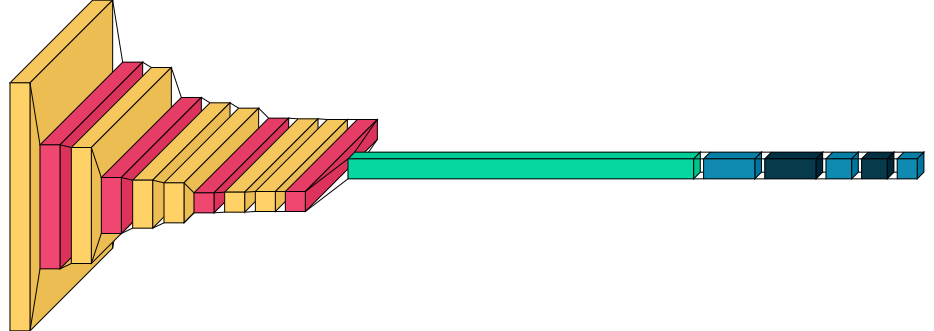

In [216]:
import visualkeras
visualkeras.layered_view(model)


In [230]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 62, 62, 8)         80        
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 62, 31, 8)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 60, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 60, 14, 16)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 58, 12, 32)        4640      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 56, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 56, 5, 32)       

In [262]:
model.predict(X_test)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [260]:
X_test = X_test.astype('float64')

In [261]:
model.predict(X_test)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [263]:
y_prediction = model.predict(X_test)
def binary_classify(y_pred):
    for inp in y_pred:
        maximum = 0
        index = 0
        for i in range(10):
            if(maximum != max(maximum,inp[i])):
                maximum = max(maximum,inp[i])
                index = i
            inp[i] = 0
        inp[index]=1
    return y_pred
y_prediction  = binary_classify(y_prediction)

In [264]:
def create_result(y):
    y_final = []
    for i in range(y.shape[0]):
        y_final.append(enc.inverse_transform(y[i].reshape(1,10))[0][0])
    return y_final 
def remove_none(y , y_pred):
    index = []
    for i in range(len(y)-1,0,-1):
        if y_pred[i] == None :
            del y[i]
            del y_pred[i]
        
    return y , y_pred
def label_encode(y , y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_pred)
    print(le.classes_)
    y = le.transform(y)
    y_pred = le.transform(y_pred)
    return y , y_pred

y_class_result = create_result(y_prediction)
y_class_desired = create_result(y_test)

In [265]:
y_label_desired , y_label_result = label_encode(y_class_desired , y_class_result) 

['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [266]:
from sklearn.metrics import classification_report
tn = []
for cat in enc.categories_[0].reshape(10,1):
    tn.append(cat[0])
target_names = tn
print(classification_report(y_label_desired, y_label_result, target_names=target_names))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00        18
         02_l       1.00      1.00      1.00        26
      03_fist       1.00      1.00      1.00        21
04_fist_moved       1.00      1.00      1.00        25
     05_thumb       1.00      1.00      1.00        20
     06_index       1.00      1.00      1.00        14
        07_ok       1.00      1.00      1.00        18
08_palm_moved       1.00      1.00      1.00        19
         09_c       1.00      1.00      1.00        19
      10_down       1.00      1.00      1.00        20

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200



In [ ]:
count = 1
f = plt.figure(figsize=(20,24))
for i in range(20):
    ind = random.sample(list(y_label_result),1)[0]
    img = X_test[ind]
    Class = str(y_class_desired[ind]) + '  vs  '+str(y_class_result[ind])
    ax = f.add_subplot(5, 4,count)
    ax = plt.imshow(img.reshape(w,h))
    ax = plt.title(Class,fontsize= 11)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()